# Quantum Fourier Transform

In this notebook, we'll be implementing the Quantum Fourier Transform from scratch.

It's well known for its use in Quantum Phase Estimation (and therefore Shor's algorithm.)

Let's get started.

In [1]:
%pip install qiskit[visualization] --quiet
%pip install matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Whereas the classical Discrete Fourier Transform takes a vector in real space $\vec{v}$ to a vector in frequency space $\vec{\tilde{v}}$, the QFT gets a quantum superposition $\sum_{k=0} v_k |k\rangle$ and transforms this superposition such that the coefficients are now what would be the values of the frequency-domain vector $\sum_{j=0} \tilde{v}_j |j\rangle$. For a generic state, the QFT acts as 

$$ QFT(\sum_{k=0} v_k |k\rangle) = \sum_{j=0} \tilde{v}_j |j\rangle$$

Therefore, we need to transform each basis state $|j\rangle$ as:

$$ |j\rangle \to \frac{1}{\sqrt{N}}\sum_{k=~0}^{N-1} e^{2\pi i j k/N} |k\rangle$$

## Implementation

We can implement this transformation using a straightforward trick: there is an equivalent representation of the above transformation. We need a couple notational tricks firts. We expand the notation of the basis state $|j\rangle$ as $|j_1 j_2 j_3 ... j_n\rangle$ where $n$ is the number of qubits, and $j_k \in \{0,1\}$. Then, we define a new notation: $0.j_{\ell}j_{\ell+1} ... j_m$ means $j_{\ell}/2 + j_{\ell+1}/4 + ... + j_m/2^{m-\ell+1}$. Finally, we can rewrite the effect of the QFT as 


$$ |j\rangle \to \frac{1}{\sqrt{N}}\sum_{k=~0}^{N-1} e^{2\pi i j k/N} |k\rangle = \frac{1}{\sqrt{N}}\left(|0\rangle + e^{2\pi i0.j_n}|1\rangle\right)\left(|0\rangle + e^{2\pi i0.j_{n-1}j_{n}}|1\rangle\right)\cdots\left(|0\rangle + e^{2\pi i0.j_1j_2...j_n}|1\rangle\right)$$

(Exercise: prove it. Alternatively, read section 5.1 of the Nielsen-Chuang)

Now it's fairly clear how to implement the QFT: we need to apply the correct phases to the $|1\rangle$ state of each qubit. To this end, we only need two kinds of gates, and one of them, the Hadamard, is already implemented in qiskit. 

We need a second (parametrized) gate to apply the phases: the controlled-$R_k$ gate (for which $k$ can be picked) applies a phase of $e^{2\pi i/2^{k}}$ to $|1\rangle$:

$$\textrm{controlled-}R_k =  \begin{pmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{2\pi i/2^{k}}\end{pmatrix}$$

Of course, this is your job. I've merely written the helpers, but you need to write down the matrix

In [1]:
from qiskit.circuit.library import UnitaryGate
from qiskit import QuantumCircuit
import numpy as np

def Rk(k:int):

    # EXERCISE: write down the matrix!
    rk_mat=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,np.exp(2j*np.pi/(2**k))]])
    return UnitaryGate(rk_mat)

def apply_controlled_rk(circ:QuantumCircuit,k:int,ctrl:int,targ:int)->None:
    rk = Rk(k)
    circ.append(rk,[ctrl,targ])


Now, we must build the circuit. 

Due to the construction, the qubits will end up backwards with respect to the original ordering, but this can easily be solved. 

Here is how we apply all the correct phases:

Starting on qubit $q_0$, we apply a Hadamard, and then from all qubits $q_m=1,...,N-1$ we apply $N-2$ controlled-$R_k$ gates with phases $m$, control qubit $q_m$ on the target $q_0$. We repeat this scheme sequentially for each qubit: $q_1$ also gets a Hadamard, and controlled-$R_k$ gates from qubits $q_m=2,...,N-1$ to $q_1$. And so on. 

Anyway, in the next exercise, you need to create the QFT circuit. I've written the functions to check that it is correct. The rest is up to you.

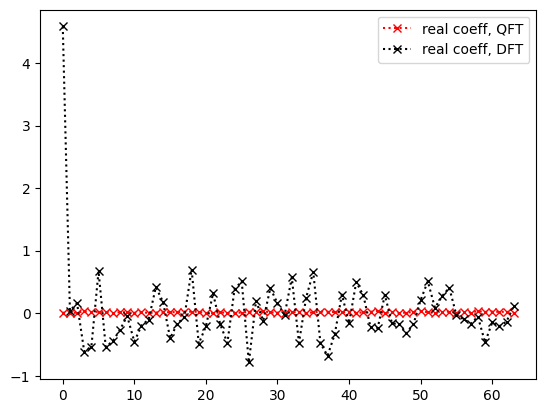

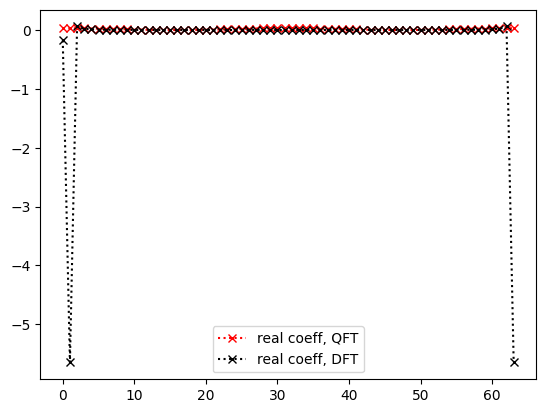

In [35]:
from scipy.fft import fft
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from qiskit.circuit.library import QFT

def qft_circuit(n_qubits:int):
    # EXERCISE: write the QFT circuit!
    # hint: use two for loops
    circuit = QuantumCircuit(n_qubits)
    for n in range(n_qubits):
        circuit.h(n)
        for j in range(n+1,n_qubits):
            apply_controlled_rk(circuit,j,j,n)
    return circuit

def get_qft_coefficients(n_qubits,initial_state:np.ndarray):
    circuit = QuantumCircuit(n_qubits)
    circuit.prepare_state(state=initial_state)
    circuit.compose(QFT(n_qubits,inverse=True,do_swaps=False))
    statevector = Statevector.from_instruction(circuit)
    return statevector.probabilities()
    

def check_results(initial_state:np.ndarray,n_qubits:int):
    
    amplitudes=get_qft_coefficients(n_qubits,initial_state)
    
    fft_amplitudes = fft(initial_state,len(initial_state))
    
    plt.plot(range(len(amplitudes)),np.real(amplitudes),"rx:",label="real coeff, QFT")
    plt.plot(range(len(amplitudes)),np.real(fft_amplitudes),"kx:",label="real coeff, DFT")
    # plt.plot(range(len(amplitudes)),np.imag(amplitudes),"bo:",label="imag coeff, QFT")
    # plt.plot(range(len(amplitudes)),np.imag(fft_amplitudes),"ko:",label="imag coeff, DFT")
    plt.legend()
    plt.show()
n_qubits=6

# RANDOM VECTOR
initial_state = np.random.rand(2**n_qubits)+1j*np.random.rand(2**n_qubits)
initial_state/=np.linalg.norm(initial_state)
check_results(initial_state,n_qubits=n_qubits)


# COS VECTOR
initial_state = np.cos(np.linspace(-np.pi,np.pi,2**n_qubits))
initial_state/=np.linalg.norm(initial_state)
check_results(initial_state,n_qubits=n_qubits)


In the end, we get the QFT, with, as expected, a gate depth that is exponentially better than classical complexity. Yet, since we cannot directly measure all the coefficients, it is not so straightforward to build quantum advantage using the QFT. Shor's algorithm does using a more subtle approach. 